In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import math
from scipy.optimize import curve_fit
import functions as model2
from cmdstanpy import CmdStanModel

In [186]:
def hazard_function_empirical_protein(df):
    protein_levels = np.asarray(df["protein_level"], dtype=float)
    protein_levels = protein_levels[np.isfinite(protein_levels)]
    protein_levels = np.sort(protein_levels)

    min_diff = 0.0001
    N_t = len(protein_levels)
    p_max = np.max(protein_levels)
    grid = np.arange(0, p_max + min_diff, min_diff)
    survival = [(protein_levels > p).sum()/N_t for p in grid]
    hazard = np.empty(len(grid)-1, dtype=float)
    for p in range(len(grid) - 1):
        if survival[p] > 0 and survival[p+1] > 0:   #Checking division by zero
            hazard[p] = - (np.log(survival[p+1]) - np.log(survival[p])) / (grid[p+1] - grid[p])
        else:
            hazard[p] = 0
    return grid, hazard/sum(hazard), survival[:-1]


def protein_level(t, m0, alpha):
    return m0 * (np.exp(alpha * t) - 1)

Remove the outlies from Lac and Ace

In [230]:
#Make a dictionary of dataframes
dfs = {}
names = []                                              
for path in glob.glob("data/*.csv"):
    if path=="data/UMIK_allSources.csv" or path=="data/df_UMIK_allSources.csv":
        continue
    name = os.path.splitext(os.path.basename(path))[0]  
    names.append(name)
    dfs[name] = pd.read_csv(path)

# Add protein levels to the dataframes
for name, df in dfs.items():
    df["protein_level"] = protein_level(df["generationtime"], df['length_birth'], df['growth_rate'])
# We used lenght instead of mass


clean_ace = dfs['UMIK_Ace'].dropna()


q1, q3 = clean_ace['protein_level'].quantile([0.25, 0.75])
iqr           = q3 - q1
lower_fence   = q1 - 1.5 * iqr
upper_fence   = q3 + 1.5 * iqr

# 4. Keep only non-outliers
clean_no_outliers = clean_ace[(clean_ace['protein_level'] >= lower_fence) & (clean_ace['protein_level'] <= upper_fence)]

# 5. (Optional) assign back to your DataFrame
df_clean_Ace = df.loc[clean_no_outliers.index].copy()
dfs['UMIK_Ace'] = df_clean_Ace
plt.figure()
plt.hist(df_clean_Ace['protein_level'], bins=100, density=True, alpha=0.5, label='Cleaned Protein Levels')
plt.show()

clean_lac = dfs['UMIK_Lac'].dropna()
q1, q3 = clean_lac['protein_level'].quantile([0.25, 0.75])
iqr = q3 - q1
lower_fence = q1 - 1.5 * iqr
upper_fence = q3 + 1.5 * iqr
# Keep only non-outliers
clean_lac_no_outliers = clean_lac[(clean_lac['protein_level'] >= lower_fence) & (clean_lac['protein_level'] <= upper_fence)]
dfs['UMIK_Lac'] = clean_lac_no_outliers

plt.figure()
plt.hist(clean_lac_no_outliers['protein_level'], bins=100, density=True, alpha=0.5, label='Cleaned Lac Protein Levels')
plt.show()

1
2
3
4
5
6
7
8
9


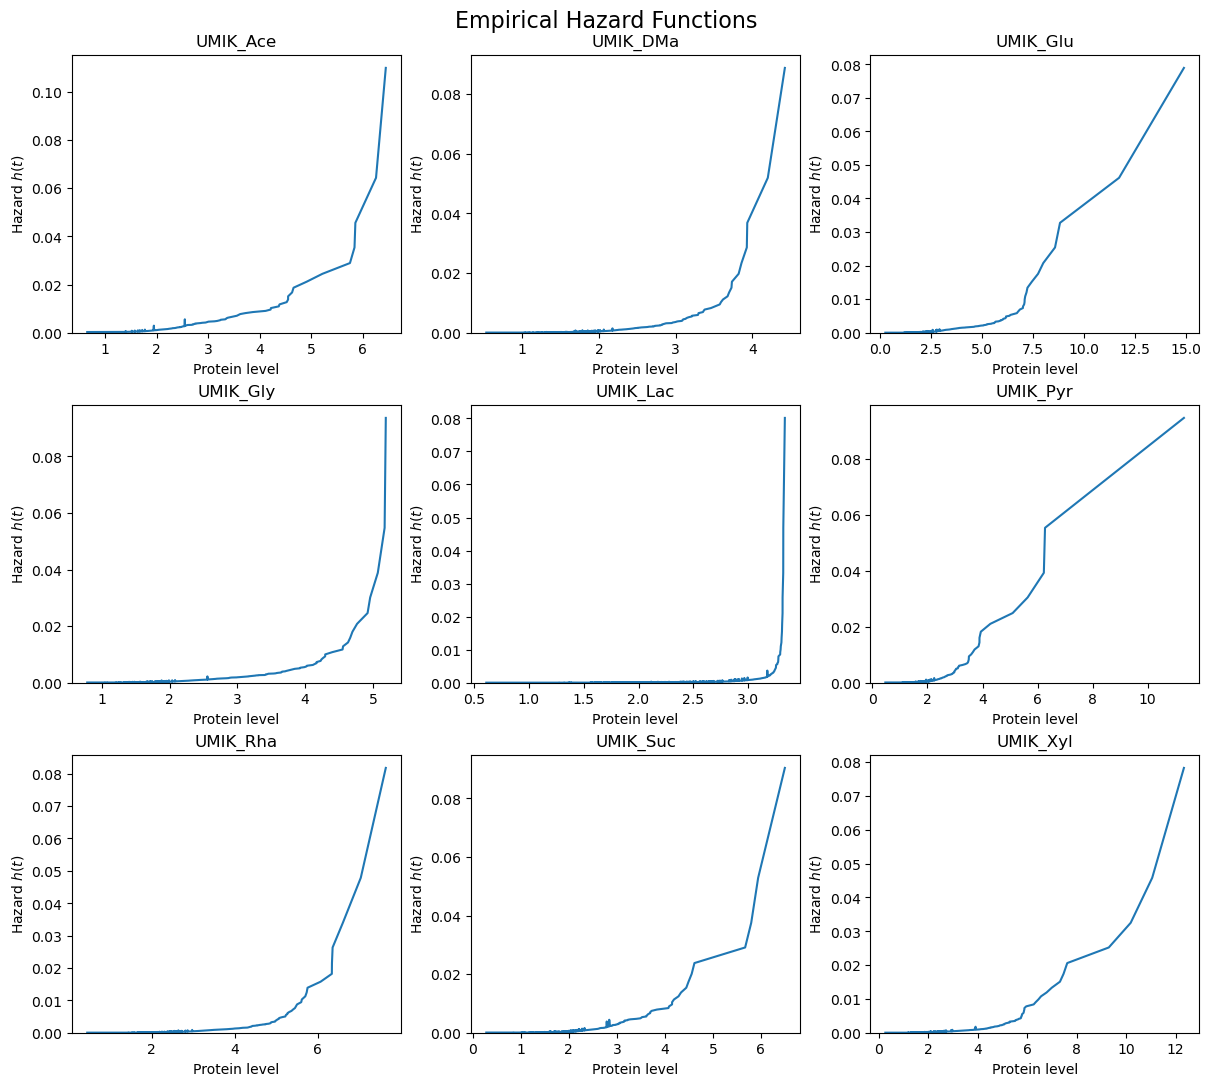

In [191]:
hazards = []
i = 0                         
for name, df in dfs.items():         
    grid, h, survival = hazard_function_empirical_protein(df)
    mask = h > 0 #remove all the values where the hazard function is 0, is this the right thing to do?
    hazards.append((name, grid[:-1][mask], h[mask]))
    i += 1
    print(i)

n_plots = len(hazards)
n_cols   = 3
n_rows   = math.ceil(n_plots / n_cols)


fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4*n_cols, 3.5*n_rows),
    sharex=False, sharey=False,
    constrained_layout=True          
)

axes = axes.flatten()               

for ax, (name, grid, h) in zip(axes, hazards):

    """#remove extreme values
    if name == "UMIK_Ace":
        grid = grid[:-1]
        h = h[:-1]
        survival = survival[:-1]
    elif name == "UMIK_Pyr":
        grid = grid[:-1]
        h = h[:-1]
        survival = survival[:-1]"""

    ax.plot(grid, h, lw=1.5)
    ax.set_title(name)
    ax.set_xlabel("Protein level")
    ax.set_ylabel("Hazard $h(t)$")
    ax.set_ylim(bottom=0)

for ax in axes[n_plots:]:
    ax.set_visible(False)

plt.suptitle("Empirical Hazard Functions", fontsize=16, y=1.02)
plt.show()

In [193]:
def logistic_survival(t, a, b):
    return 1 / (1 + np.exp(a * (t - b)))

def generalized_logistic_survival(t, tau, k, alpha):
    return 1 / (1 + (t / tau)**k)**alpha

def generalized_logistic_hazard(t, tau, k, alpha):
    t = np.asarray(t)
    term = (t / tau)
    numerator = alpha * k / tau * term**(k - 1)
    denominator = 1 + term**k
    return numerator / denominator

# Survival and Hazard funciton as a funcion of protein level

$S(p) = \frac{1}{\left(1 + \left( \frac{p}{\tau} \right)^k \right)^{a}}$

$h(p) = \frac{a k}{\tau^k} \cdot \frac{p^{k-1}}{1 + \left( \frac{p}{\tau} \right)^k}$

$f(p) = \frac{a \cdot k \cdot p^{k-1}}{\tau^k \left(1 + \left( \frac{p}{\tau} \right)^k \right)^{a + 1}}$

$p$: independent variable (protein level)

$\tau$: inflection point (location)

$k$: shape/steepness

$a$: scale or tail weight parameter

# Survival and Hazard funciton as a funcion of time

$p(t) = c m_D \left(e^{\alpha t} - 1\right)$ : Protein growth as a function of time $t$


$S(t) = \frac{1}{\left(1 + \left( \frac{c m_D (e^{\alpha t} - 1)}{\tau} \right)^k \right)^{\alpha}}$

$h(t) = \left[ \frac{\alpha k}{\tau} \cdot \frac{\left( \frac{p(t)}{\tau} \right)^{k-1}}{1 + \left( \frac{p(t)}{\tau} \right)^k} \right] \cdot c m_D \alpha e^{\alpha t}$

# Find the Fitted Parameters

UMIK_Ace
UMIK_DMa
UMIK_Glu
UMIK_Gly
UMIK_Lac
UMIK_Pyr
UMIK_Rha
UMIK_Suc
UMIK_Xyl


C:\Users\yusuf\AppData\Local\Temp\ipykernel_14020\2431327484.py:5: RuntimeWarning: invalid value encountered in power
  return 1 / (1 + (t / tau)**k)**alpha
C:\Users\yusuf\AppData\Local\Temp\ipykernel_14020\2431327484.py:5: RuntimeWarning: divide by zero encountered in power
  return 1 / (1 + (t / tau)**k)**alpha


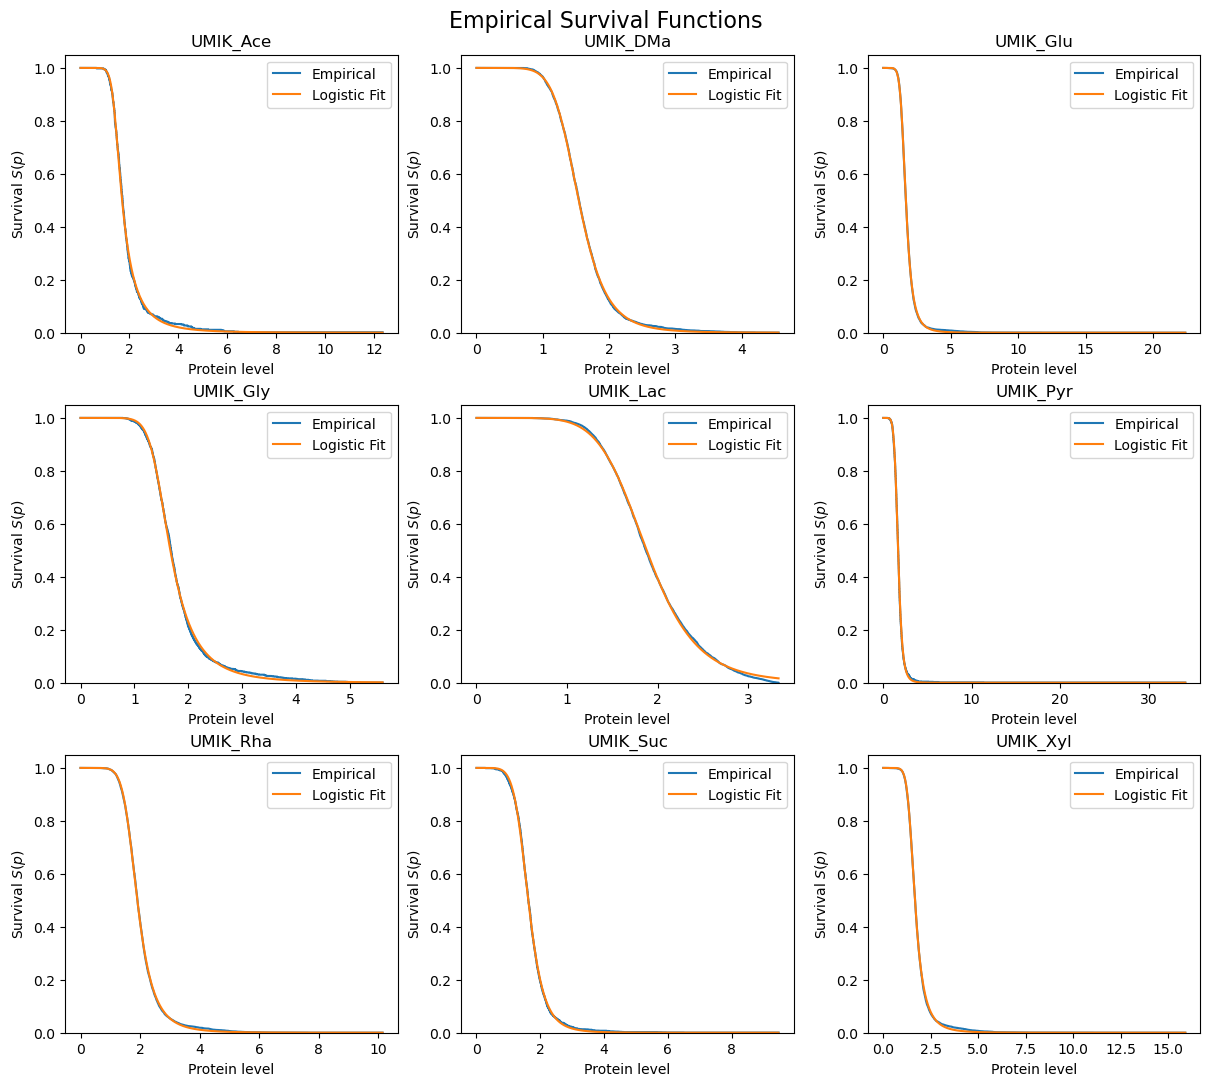

In [198]:
hazards = []                         

for name, df in dfs.items():
    print(name)         
    grid, h, survival = hazard_function_empirical_protein(df)
    hazards.append((name, grid[:-1], h, survival))

n_plots = len(hazards)
n_cols   = 3
n_rows   = math.ceil(n_plots / n_cols)


fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4*n_cols, 3.5*n_rows),
    sharex=False, sharey=False,
    constrained_layout=True          
)

axes = axes.flatten()               
fittingParams = []

for ax, (name, grid, h, survival) in zip(axes, hazards):

    popt, _ = curve_fit(generalized_logistic_survival, grid, survival, p0=[1, 1, 1])
    grid_fit = np.linspace(min(grid), max(grid), len(grid))
    survival_fit = generalized_logistic_survival(grid_fit, *popt)
    fittingParams.append(popt)
    
    ax.plot(grid, survival, lw=1.5, label='Empirical')
    ax.plot(grid_fit, survival_fit, label='Logistic Fit')

    ax.set_title(name)
    ax.set_xlabel("Protein level")
    ax.set_ylabel("Survival $S(p)$")
    ax.set_ylim(bottom=0)
    ax.legend()

for ax in axes[n_plots:]:
    ax.set_visible(False)

plt.suptitle("Empirical Survival Functions", fontsize=16, y=1.02)
plt.show()

fittingParams = pd.DataFrame(fittingParams)
fittingParams.columns = ["u", "v", "omega2"]

In [199]:
sugars = ["Ace", "DMa", "Glu", "Gly", "Lac", "Pyr", "Rha", "Suc", "Xyl"]

fittingParams.index = sugars

fittingParams

,u,v,omega2
Ace,1.435071,10.902389,0.348062
DMa,1.520967,7.687937,0.926973
Glu,1.545852,8.271839,0.644072
Gly,1.486254,9.993666,0.487834
Lac,1.920109,6.635224,1.111569
Pyr,1.695653,6.883056,1.060456
Rha,1.777183,8.197721,0.675184
Suc,1.627657,6.696428,1.008733
Xyl,1.503152,9.208714,0.543765


C:\Users\yusuf\AppData\Local\Temp\ipykernel_14020\4150033906.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[0].text(u[i], v[i], label, fontsize=10, ha='right', va='bottom')
C:\Users\yusuf\AppData\Local\Temp\ipykernel_14020\4150033906.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[1].text(u[i], w[i], label, fontsize=10, ha='right', va='bottom')
C:\Users\yusuf\AppData\Local\Temp\ipykernel_14020\4150033906.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acce

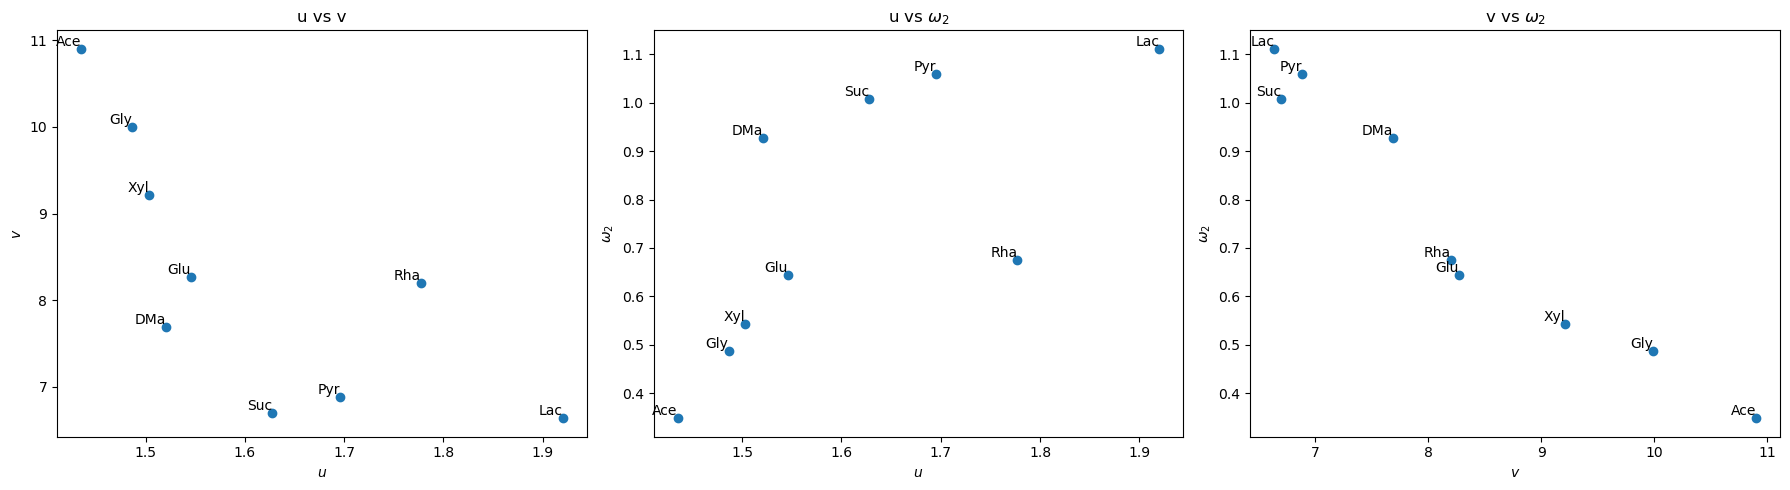

In [202]:
u = fittingParams["u"]
v = fittingParams["v"]
w = fittingParams["omega2"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# Plot 1: u vs v
axes[0].scatter(u, v)
for i, label in enumerate(sugars):
    axes[0].text(u[i], v[i], label, fontsize=10, ha='right', va='bottom')
axes[0].set_xlabel('$u$')
axes[0].set_ylabel('$v$')
axes[0].set_title('u vs v')

# Plot 2: u vs omega2
axes[1].scatter(u, w)
for i, label in enumerate(sugars):
    axes[1].text(u[i], w[i], label, fontsize=10, ha='right', va='bottom')
axes[1].set_xlabel('$u$')
axes[1].set_ylabel(r'$\omega_2$')
axes[1].set_title(r'u vs $\omega_2$')

# Plot 3: v vs omega2
axes[2].scatter(v, w)
for i, label in enumerate(sugars):
    axes[2].text(v[i], w[i], label, fontsize=10, ha='right', va='bottom')
axes[2].set_xlabel('$v$')
axes[2].set_ylabel(r'$\omega_2$')
axes[2].set_title(r'v vs $\omega_2$')

plt.tight_layout()
plt.show()


# Hazard function from survial fit (DMa)

In [205]:
grid = hazards[1][1]
h = hazards[1][2]
survival = hazards[1][3]

In [207]:
popt, _ = curve_fit(generalized_logistic_survival, grid, survival, p0=[1, 1, 1])
grid_fit = np.linspace(min(grid), max(grid), len(grid))
popt = np.array([1.50, 7.91, 0.85])
survival_fit = generalized_logistic_survival(grid_fit, *popt)

popt

array([1.5 , 7.91, 0.85])

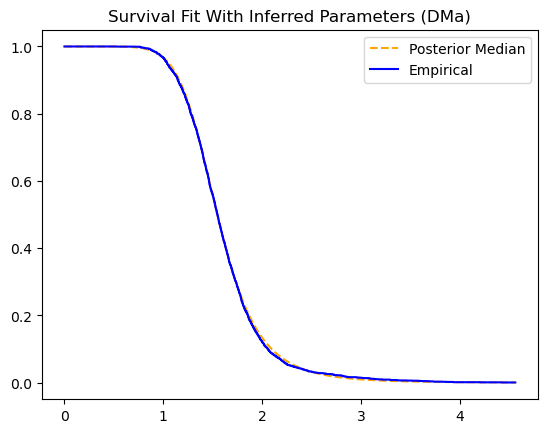

In [209]:
plt.plot(grid_fit, survival_fit, color='orange', linestyle='--', label='Posterior Median')
plt.plot(grid, survival, lw=1.5, label='Empirical', color='blue')
plt.title("Survival Fit With Inferred Parameters (DMa)")
plt.legend()

In [211]:
hazard = np.empty(len(grid)-1, dtype=float)
for p in range(len(grid) - 1):
    if survival_fit[p] > 0 and survival_fit[p+1] > 0:
        hazard[p] = - (np.log(survival_fit[p+1]) - np.log(survival_fit[p])) / (grid_fit[p+1] - grid_fit[p])
    else:
        hazard[p] = 0

Text(0.5, 1.0, 'hazard from survival fit (DMa)')

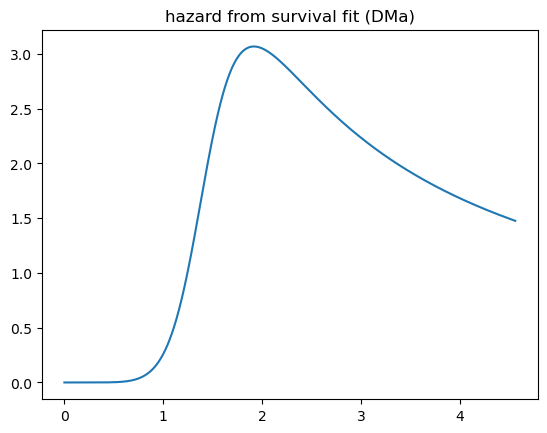

In [213]:
plt.plot(grid_fit[:-1],hazard)
plt.title("hazard from survival fit (DMa)")

# Synthetic Data

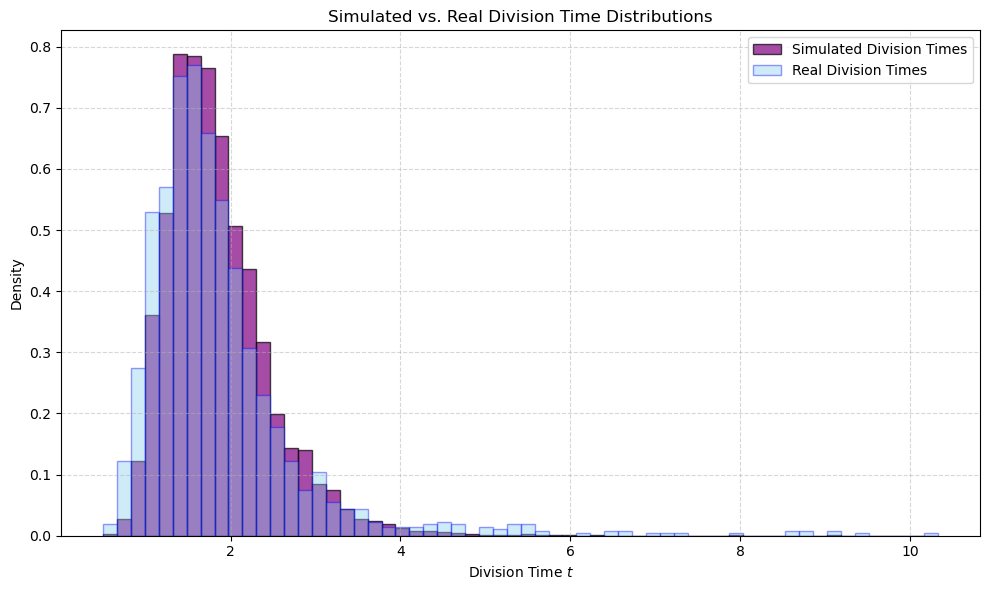

In [182]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy.stats import gamma
import pandas as pd

# --- Generalized logistic survival function in protein level ---
def generalized_logistic_survival_5_param(t, tau, k, alpha_S, m0, alpha):
    p = m0 * (np.exp(alpha * t) - 1)
    return 1 / (1 + (p / tau)**k)**alpha_S

# --- Simulate division times using inverse transform sampling ---
def simulate_division_times_generalized_logistic(n_samples, params, m_list, t_max=30.0):
    tau, k, alpha_S, mu_alpha, sigma_alpha = params
    division_times = []

    # Convert μ, σ to Gamma shape/scale
    shape = (mu_alpha / sigma_alpha)**2
    scale = sigma_alpha**2 / mu_alpha
    i = 0
    for _ in range(n_samples):
        if i >= len(m_list):
            i = 0
        m0 = m_list.iloc[i]
        #m0 = m_list.mean()
        i += 1
        alpha = gamma.rvs(a=shape, scale=scale)
        u_random = np.random.uniform()

        def survival_root(t):
            return generalized_logistic_survival_5_param(t, tau, k, alpha_S, m0, alpha) - u_random

        try:
            t0 = np.log((tau / m0) + 1) / alpha
            res = root_scalar(survival_root, bracket=[t0, t_max], method='brentq')
            if res.converged:
                division_times.append(res.root)
            else:
                division_times.append(t_max)
        except:
            division_times.append(t_max)

    division_times = np.array(division_times)
    return division_times[division_times < t_max]  # Ensure clean truncation
popt = np.array([1.50,7.91,0.85])
# --- Example posterior parameters ---
"""tau = 1.07
k = 2.96
alpha_S = 1.85
mu_alpha = 0.32
sigma_alpha = 0.08"""

tau = 1.50
k = 9.46
alpha_S = 0.52
mu_alpha = 0.35
sigma_alpha = 0.08

posterior_params = [tau, k, alpha_S, mu_alpha, sigma_alpha]

# --- Load or assume real data ---
if "dfs" not in globals():
    # Dummy data fallback
    print("Warning: dfs not defined, creating dummy data for testing.")
    length_birth = np.random.uniform(1.5, 2.5, size=1000)
    generationtime = np.random.exponential(scale=2.0, size=1000)
    df = pd.DataFrame({'length_birth': length_birth, 'generationtime': generationtime})
else:
    df = dfs["UMIK_Gly"]

real_div_times = df["generationtime"].dropna().values
masses = df["length_birth"].dropna()

# --- Simulate ---
n_samples = 10000
simulated_div_times = simulate_division_times_generalized_logistic(n_samples, posterior_params, masses)

# --- Match histogram binning ---
if len(real_div_times) == 0 or len(simulated_div_times) == 0:
    raise ValueError("Real or simulated division times are empty. Check data inputs.")

combined_times = np.concatenate((real_div_times, simulated_div_times))
min_t, max_t = np.min(combined_times), np.max(combined_times)
n_bins = 60
bins = np.linspace(min_t, max_t, n_bins + 1)

# --- Plot ---
plt.figure(figsize=(10, 6))

plt.hist(simulated_div_times, bins=bins, density=True, alpha=0.7,
         color='purple', edgecolor='black', label='Simulated Division Times')

plt.hist(real_div_times, bins=bins, density=True, alpha=0.4,
         color='skyblue', edgecolor='blue', label='Real Division Times')

plt.title("Simulated vs. Real Division Time Distributions")
plt.xlabel("Division Time $t$")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [223]:
data = [
    ["Ace", 1.08, 5.44, 0.78, 0.50, 0.03, 0.17, 0.05],
    ["DMa", 1.07, 2.96, 1.85, 0.52, 0.03, 0.32, 0.08],
    ["Glu", 1.23, 2.79, 1.66, 0.57, 0.04, 0.54, 0.15],
    ["Gly", 1.39, 3.99, 1.37, 0.55, 0.04, 0.35, 0.08],
    ["Lac", 1.74, 1.74, 1.33, 0.60, 0.04, 0.50, 0.13],
    ["Pyr", 1.26, 3.43, 1.50, 0.52, 0.04, 0.37, 0.12],
    ["Rha", 1.57, 5.08, 1.00, 0.54, 0.04, 0.26, 0.06],
    ["Suc", 1.31, 3.32, 1.51, 0.51, 0.04, 0.29, 0.10],
    ["Xyl", 1.28, 3.49, 1.17, 0.57, 0.04, 0.42, 0.09]
]

# Define the column names
columns = ["Sugar", "u", "v", "omega2", "μ_f", "σ_f", "μ_α", "σ_α"]

# Create the DataFrame
mc_params = pd.DataFrame(data, columns=columns)
mc_params = mc_params.set_index("Sugar");
# Display the DataFrame
mc_params

,u,v,omega2,μ_f,σ_f,μ_α,σ_α
Sugar,,,,,,,
Ace,1.08,5.44,0.78,0.50,0.03,0.17,0.05
DMa,1.07,2.96,1.85,0.52,0.03,0.32,0.08
Glu,1.23,2.79,1.66,0.57,0.04,0.54,0.15
Gly,1.39,3.99,1.37,0.55,0.04,0.35,0.08
Lac,1.74,1.74,1.33,0.60,0.04,0.50,0.13
Pyr,1.26,3.43,1.50,0.52,0.04,0.37,0.12
Rha,1.57,5.08,1.00,0.54,0.04,0.26,0.06
Suc,1.31,3.32,1.51,0.51,0.04,0.29,0.10
Xyl,1.28,3.49,1.17,0.57,0.04,0.42,0.09


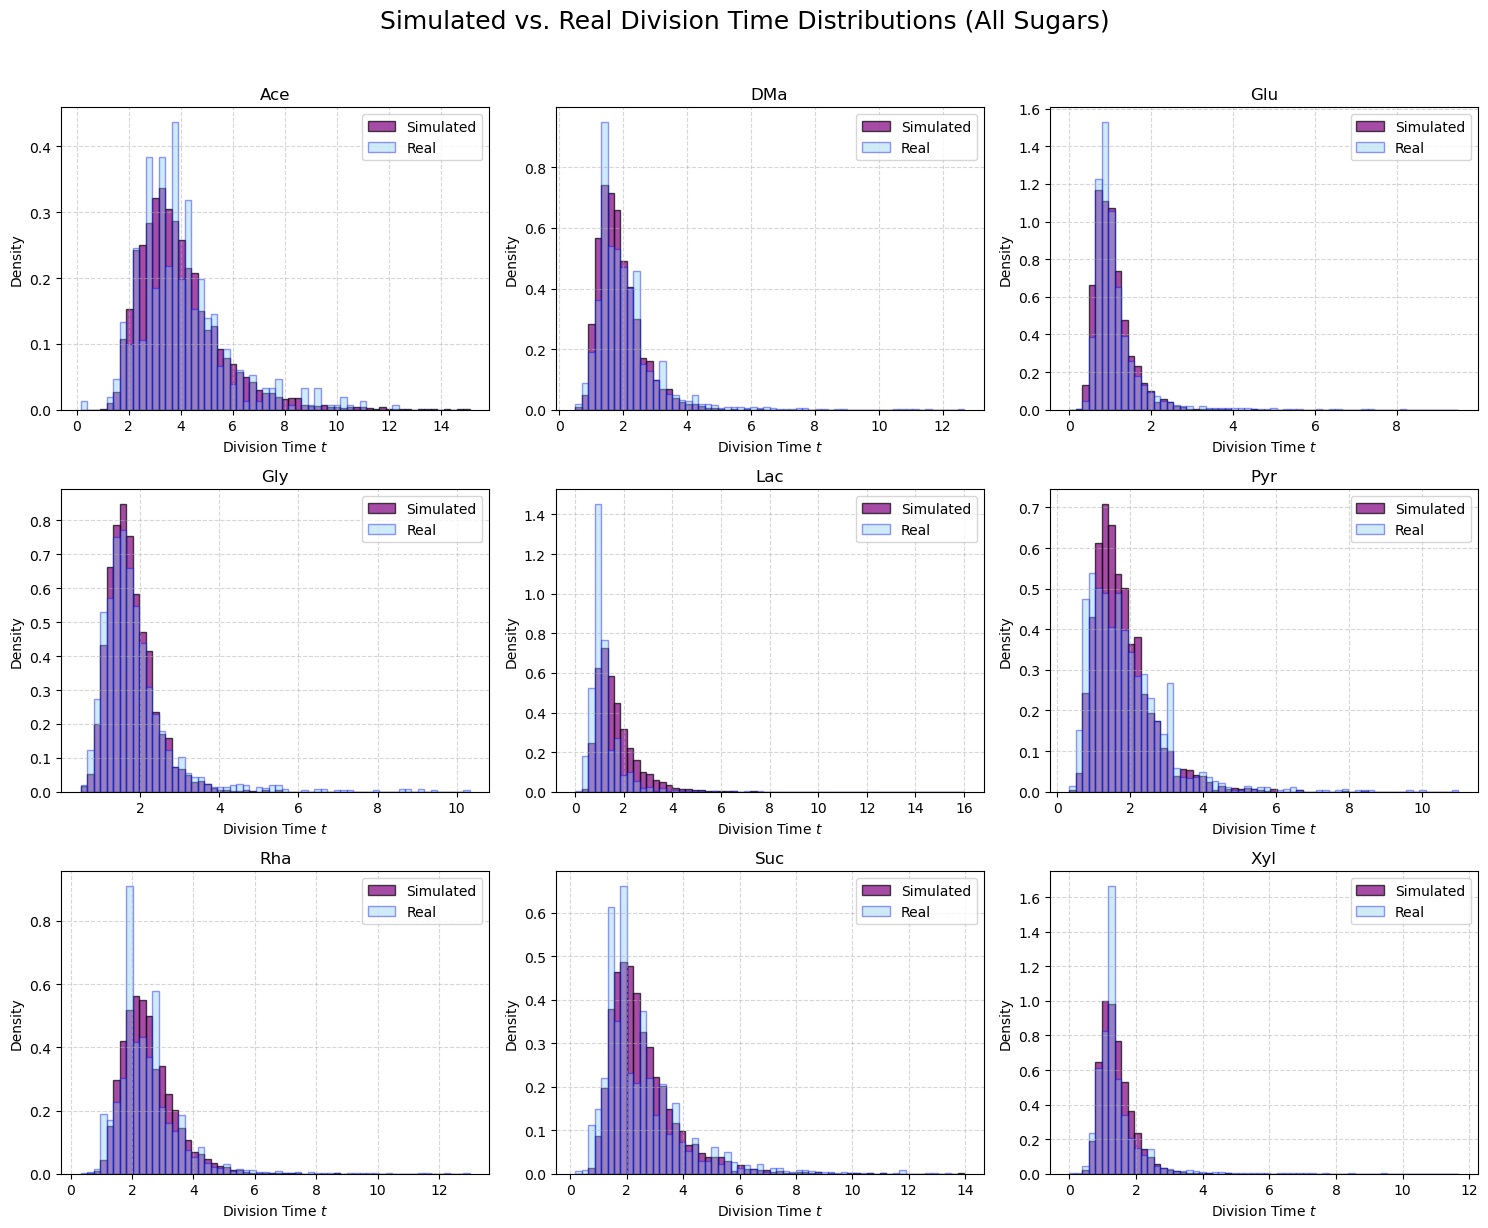

In [232]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()  # Flatten for easy indexing

n_bins = 60
n_samples = 10000

for j in range(len(sugars)):
    tau = mc_params.loc[sugars[j]].iloc[0]
    k = mc_params.loc[sugars[j]].iloc[1]
    alpha_S = mc_params.loc[sugars[j]].iloc[2]
    mu_alpha = mc_params.loc[sugars[j]].iloc[5]
    sigma_alpha = mc_params.loc[sugars[j]].iloc[6]
    posterior_params = [tau, k, alpha_S, mu_alpha, sigma_alpha]

    df = dfs[f"UMIK_{sugars[j]}"]

    real_div_times = df["generationtime"].dropna().values
    masses = df["length_birth"].dropna()
    
    simulated_div_times = simulate_division_times_generalized_logistic(n_samples, posterior_params, masses)
    
    if len(real_div_times) == 0 or len(simulated_div_times) == 0:
        raise ValueError(f"Empty real or simulated division times for sugar {sugars[j]}")

    combined_times = np.concatenate((real_div_times, simulated_div_times))
    min_t, max_t = np.min(combined_times), np.max(combined_times)
    bins = np.linspace(min_t, max_t, n_bins + 1)

    ax = axes[j]
    ax.hist(simulated_div_times, bins=bins, density=True, alpha=0.7,
            color='purple', edgecolor='black', label='Simulated')
    ax.hist(real_div_times, bins=bins, density=True, alpha=0.4,
            color='skyblue', edgecolor='blue', label='Real')
    
    ax.set_title(sugars[j])
    ax.set_xlabel("Division Time $t$")
    ax.set_ylabel("Density")
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend()

# Hide unused subplots if any
for j in range(len(sugars), len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Simulated vs. Real Division Time Distributions (All Sugars)", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()


In [60]:
data = [
    ["Ace", 1.08, 5.44, 0.78, 0.50, 0.03, 0.17, 0.05],
    ["DMa", 1.07, 2.96, 1.85, 0.52, 0.03, 0.32, 0.08],
    ["Glu", 1.23, 2.79, 1.66, 0.57, 0.04, 0.54, 0.15],
    ["Gly", 1.39, 3.99, 1.37, 0.55, 0.04, 0.35, 0.08],
    ["Lac", 1.74, 1.74, 1.33, 0.60, 0.04, 0.50, 0.13],
    ["Pyr", 1.26, 3.43, 1.50, 0.52, 0.04, 0.37, 0.12],
    ["Rha", 1.57, 5.08, 1.00, 0.54, 0.04, 0.26, 0.06],
    ["Suc", 1.31, 3.32, 1.51, 0.51, 0.04, 0.29, 0.10],
    ["Xyl", 1.28, 3.49, 1.17, 0.57, 0.04, 0.42, 0.09]
]

# Define the column names
columns = ["Sugar", "u", "v", "omega2", "μ_f", "σ_f", "μ_α", "σ_α"]

# Create the DataFrame
mc_params = pd.DataFrame(data, columns=columns)
mc_params = mc_params.set_index("Sugar");
# Display the DataFrame
mc_params

,u,v,omega2,μ_f,σ_f,μ_α,σ_α
Sugar,,,,,,,
Ace,1.08,5.44,0.78,0.50,0.03,0.17,0.05
DMa,1.07,2.96,1.85,0.52,0.03,0.32,0.08
Glu,1.23,2.79,1.66,0.57,0.04,0.54,0.15
Gly,1.39,3.99,1.37,0.55,0.04,0.35,0.08
Lac,1.74,1.74,1.33,0.60,0.04,0.50,0.13
Pyr,1.26,3.43,1.50,0.52,0.04,0.37,0.12
Rha,1.57,5.08,1.00,0.54,0.04,0.26,0.06
Suc,1.31,3.32,1.51,0.51,0.04,0.29,0.10
Xyl,1.28,3.49,1.17,0.57,0.04,0.42,0.09


# Load the Saved txt File to Obtain Results

In [69]:
chain = np.loadtxt("chain_DMa.txt")  # shape: (n_samples, n_params)

In [83]:
param_names = ["u", "v", "k", "alpha2", "beta2", "alpha1", "scale1"]

for i, name in enumerate(param_names):
    samples = chain[:, i]
    lower = np.percentile(samples, 2.5)
    median = np.percentile(samples, 50)
    upper = np.percentile(samples, 97.5)
    print(f"{name}: {median:.3f} (95% CI: [{lower:.3f}, {upper:.3f}])")


u: 1.496 (95% CI: [1.458, 1.537])
v: 7.908 (95% CI: [7.452, 8.389])
k: 0.850 (95% CI: [0.748, 0.969])
alpha2: 133.075 (95% CI: [125.871, 140.572])
beta2: 125.237 (95% CI: [118.444, 132.289])
alpha1: 15.539 (95% CI: [14.704, 16.411])
scale1: 0.021 (95% CI: [0.020, 0.022])


In [100]:
import numpy as np
import pandas as pd

# File and parameter setup
sugars = ["Ace", "DMa", "Glu", "Gly", "Lac", "Pyr", "Rha", "Suc", "Xyl"]
param_names = ["u", "v", "k", "mu_f", "sigma_f", "mu_alpha", "sigma_alpha"]

# Containers for each table
median_data = []
ci_data = []

for sugar in sugars:
    chain = np.loadtxt(f"chain_{sugar}.txt")
    median_row = {"Sugar": sugar}
    ci_row = {"Sugar": sugar}

    for i, param in enumerate(param_names):
        samples = chain[:, i]
        lower = round(np.percentile(samples, 2.5), 4)
        median = round(np.percentile(samples, 50), 2)
        upper = round(np.percentile(samples, 97.5), 4)

        median_row[param] = median
        ci_row[param] = f"({lower}, {upper})"  # ✅ Add CI for all

    median_data.append(median_row)
    ci_data.append(ci_row)

# Create DataFrames
df_median = pd.DataFrame(median_data)
df_ci = pd.DataFrame(ci_data)

# Display the tables
print("Median Values Table:")
print(df_median.to_string(index=False))

print("\nCredibility Intervals Table (95% CI for all parameters):")
print(df_ci.to_string(index=False))


Median Values Table:
Sugar    u    v    k   mu_f  sigma_f  mu_alpha  sigma_alpha
  Ace 1.60 8.18 1.70 113.14   114.96     12.05         0.01
  DMa 1.50 7.91 0.85 133.07   125.24     15.54         0.02
  Glu 1.53 8.37 0.61  82.48    61.76     12.82         0.04
  Gly 1.50 9.46 0.52 102.32    82.14     16.78         0.02
  Lac 2.02 6.40 1.37  95.69    65.28     14.98         0.03
  Pyr 1.63 7.11 0.89  64.98    59.34     10.00         0.04
  Rha 1.77 8.13 0.67  82.49    71.03     19.55         0.01
  Suc 1.63 6.50 1.01  96.74    93.49      7.91         0.04
  Xyl 1.50 8.97 0.55  86.20    65.33     21.38         0.02

Credibility Intervals Table (95% CI for all parameters):
Sugar                u                v                k                 mu_f              sigma_f           mu_alpha      sigma_alpha
  Ace (1.4835, 1.7947) (7.1116, 9.3983)  (1.096, 3.0437) (100.3364, 127.1729) (101.9727, 129.2455) (10.6934, 13.5269) (0.0125, 0.0159)
  DMa (1.4584, 1.5366) (7.4519, 8.3891) (0.7477, 0.

# Fit with Inferred Parameters

Plotting: UMIK_Ace


C:\Users\yusuf\AppData\Local\Temp\ipykernel_14020\642529813.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  popt = [params[0], params[1], params[2]]  # u, v, omega2


Plotting: UMIK_DMa
Plotting: UMIK_Glu
Plotting: UMIK_Gly
Plotting: UMIK_Lac
Plotting: UMIK_Pyr
Plotting: UMIK_Rha
Plotting: UMIK_Suc
Plotting: UMIK_Xyl


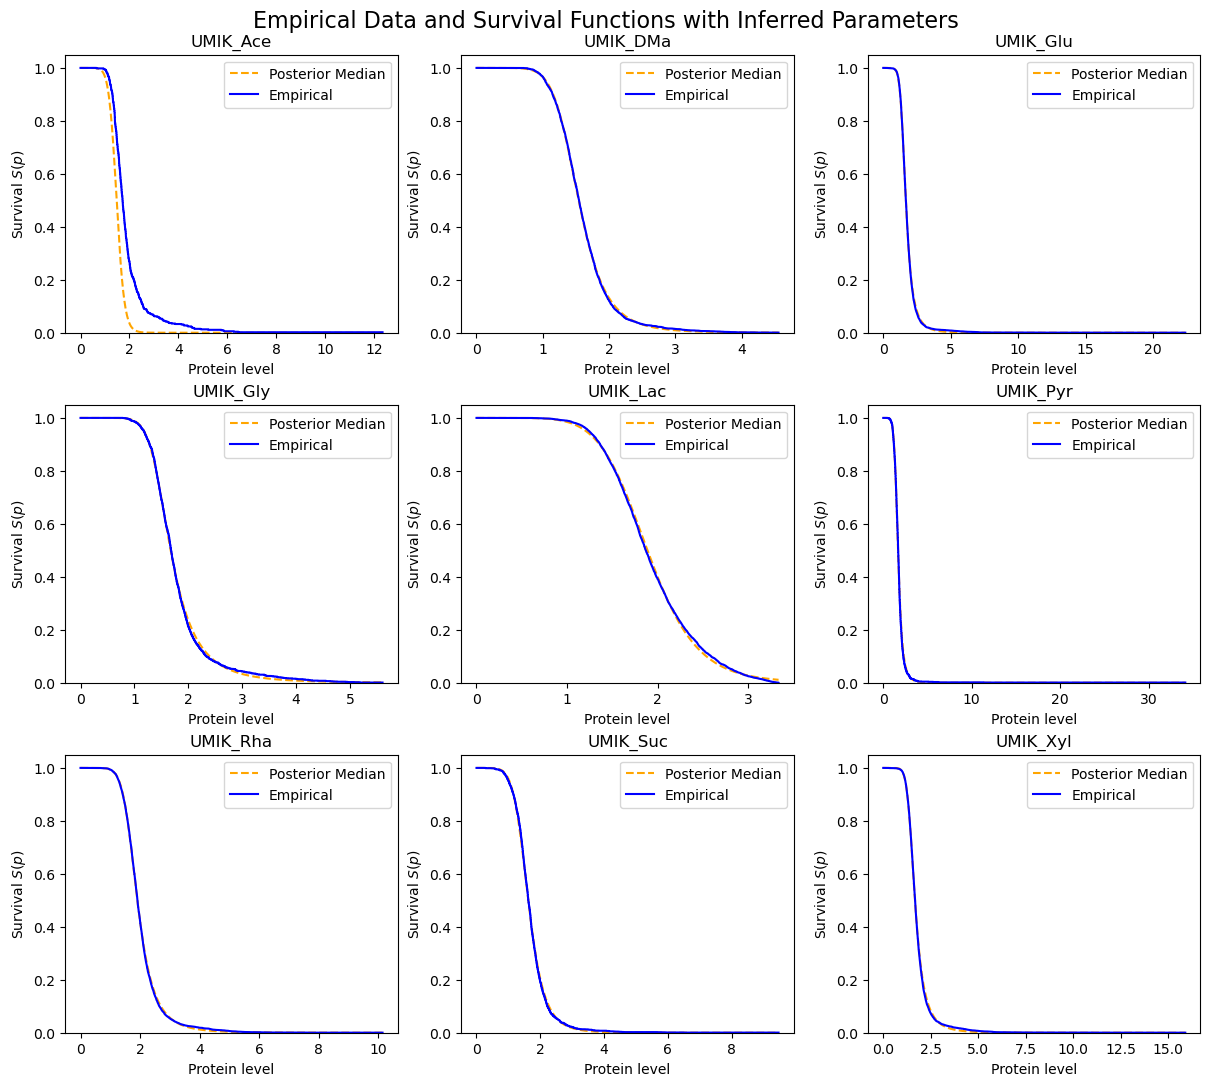

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math
import pandas as pd
import os

# You already have dfs, hazard_function_empirical_protein, generalized_logistic_survival defined

"""hazards = []
for name, df in dfs.items():
    print(name)
    grid, h, survival = hazard_function_empirical_protein(df)
    hazards.append((name, grid[:-1], h, survival))

n_plots = len(hazards)
n_cols = 3
n_rows = math.ceil(n_plots / n_cols)"""

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4 * n_cols, 3.5 * n_rows),
    sharex=False, sharey=False,
    constrained_layout=True
)

axes = axes.flatten()
fittingParams = []
i = 0

for ax, (name, grid, h, survival) in zip(axes, hazards):
    print("Plotting:", name)

    # Fitted params from posterior medians (mc_params must be defined externally)
    params = mc_params.loc[sugars[i]]
    i += 1
    popt = [params[0], params[1], params[2]]  # u, v, omega2

    # Compute logistic fit
    grid_fit = np.linspace(min(grid), max(grid), len(grid))
    survival_fit = generalized_logistic_survival(grid_fit, *popt)
    fittingParams.append(popt)

    # Load MCMC chain
    chain_file = f"chain_{name.split('_')[-1]}.txt"
    if os.path.exists(chain_file):
        flat_chain = np.loadtxt(chain_file)
        posterior_samples = flat_chain[np.random.choice(flat_chain.shape[0], size=200, replace=False)]

        # Compute survival curves from posterior
        all_survivals = []
        for sample in posterior_samples:
            u, v, omega2 = sample[:3]
            surv = generalized_logistic_survival(grid_fit, u, v, omega2)
            all_survivals.append(surv)

        all_survivals = np.array(all_survivals)
        lower = np.percentile(all_survivals, 2.5, axis=0)
        upper = np.percentile(all_survivals, 97.5, axis=0)
        
        #lower = np.percentile(all_survivals, 12.5, axis=0)
        #upper = np.percentile(all_survivals, 87.5, axis=0)
        
        median = np.percentile(all_survivals, 50, axis=0)

        #ax.fill_between(grid_fit, lower, upper, alpha=0.3, color='orange', label='95% CI')
        ax.plot(grid_fit, median, color='orange', linestyle='--', label='Posterior Median')

    ax.plot(grid, survival, lw=1.5, label='Empirical', color='blue')
    #ax.plot(grid_fit, survival_fit, lw=1.5, label='Logistic Fit', color='green')

    ax.set_title(name)
    ax.set_xlabel("Protein level")
    ax.set_ylabel("Survival $S(p)$")
    ax.set_ylim(bottom=0)
    ax.legend()

for ax in axes[n_plots:]:
    ax.set_visible(False)

plt.suptitle("Empirical Data and Survival Functions with Inferred Parameters", fontsize=16, y=1.02)
plt.show()


# Plot the Corner and Chain Plots

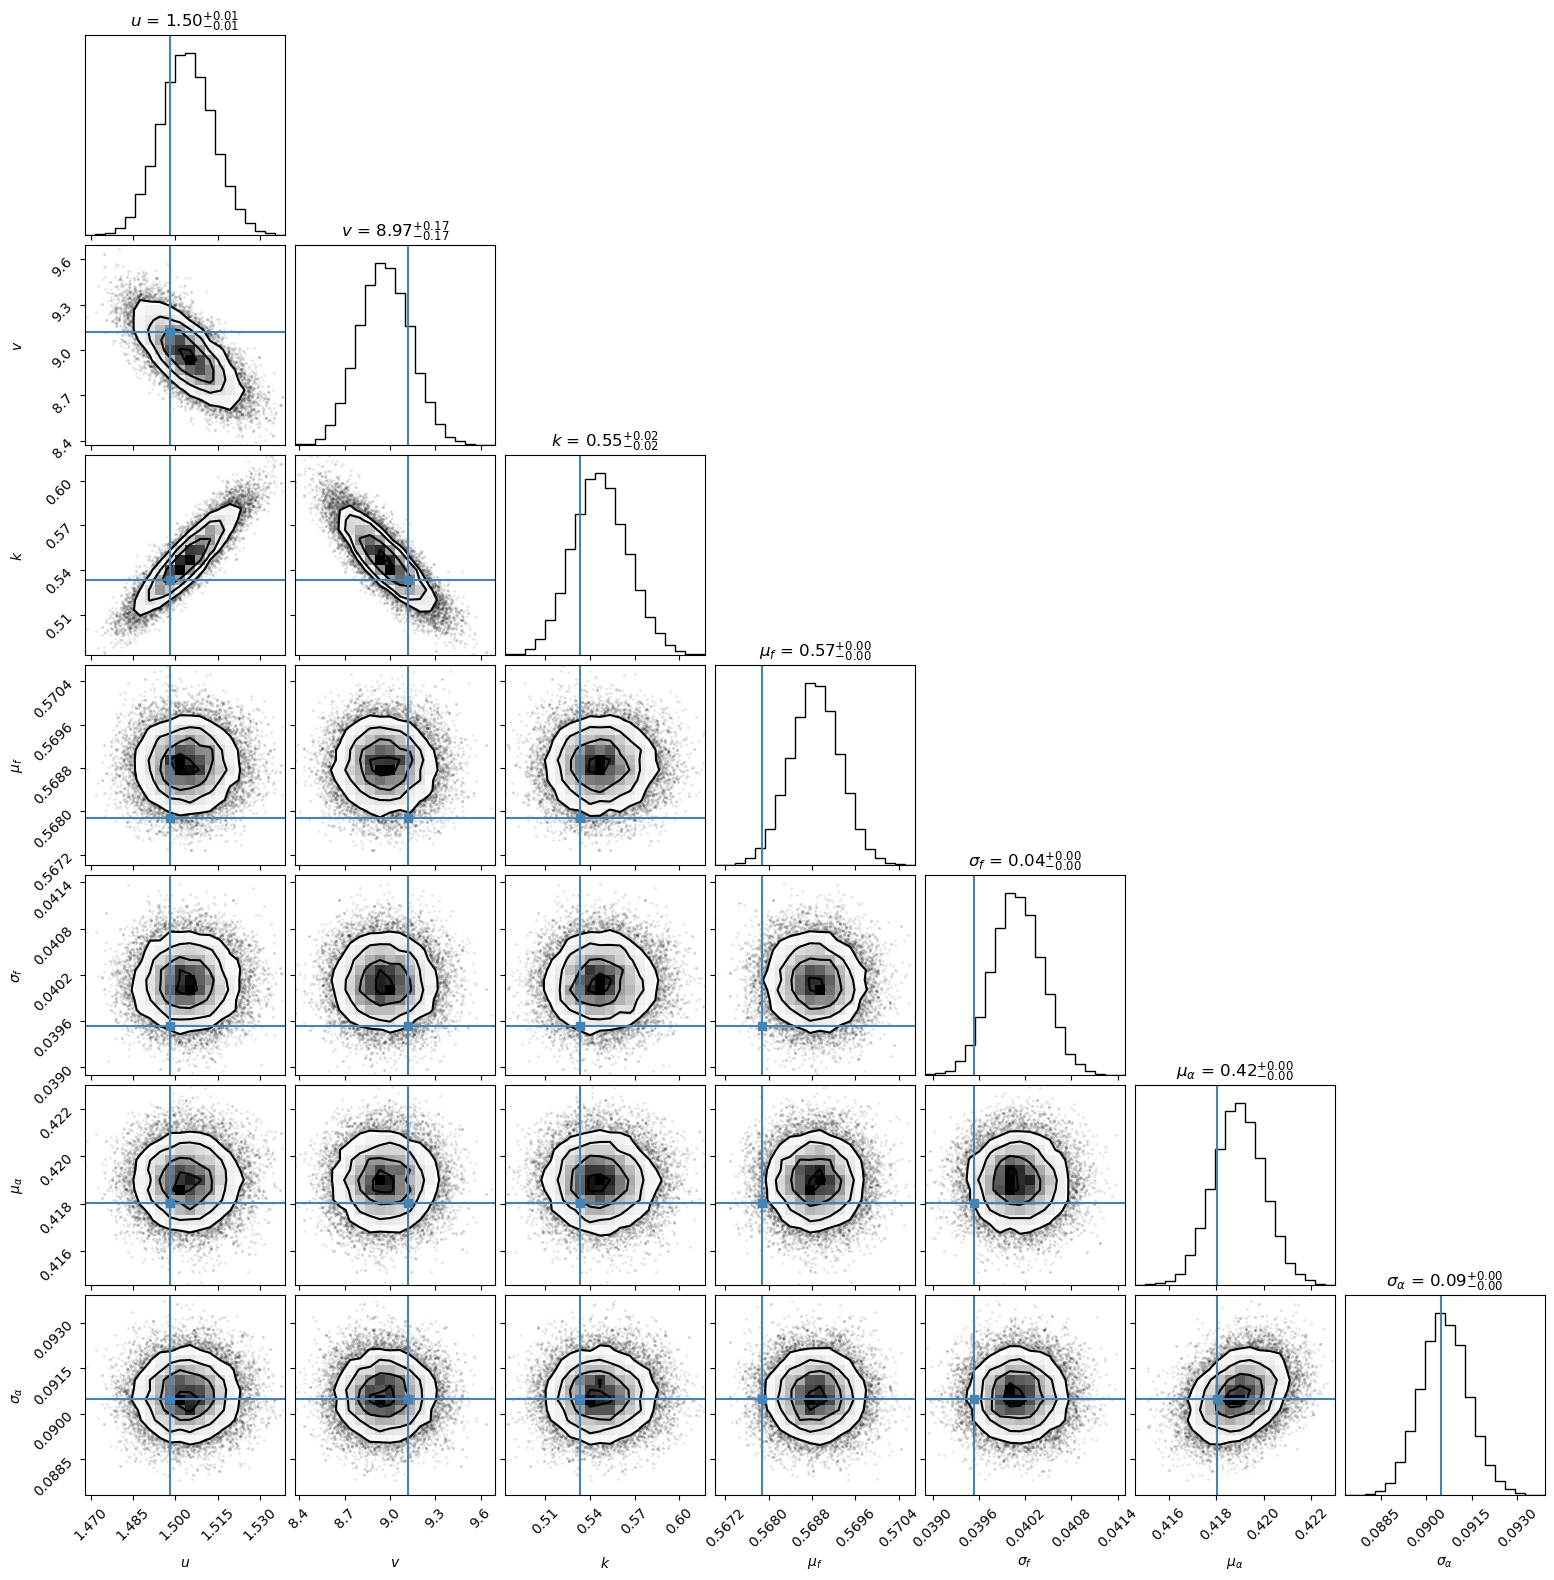

In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import corner

sugar = "Xyl"  # or whichever sugar you're analyzing
chain = np.loadtxt(f"chain_{sugar}.txt")  # shape: (n_samples, n_params)

#  thinning and burn-in
discard = 200
thin = 25
flat_samples = chain[discard::thin]  # already flattened and thinned

# Convert to DataFrame and add derived parameters
samplesdf = pd.DataFrame(flat_samples, columns=["u", "v", "k", "alpha2", "beta2", "alpha1", "scale1"])

# Derive mean/std of beta (f) and gamma (alpha) distributions
samplesdf["mean_f"] = samplesdf["alpha2"] / (samplesdf["alpha2"] + samplesdf["beta2"])
samplesdf["std_f"] = np.sqrt((samplesdf["alpha2"] * samplesdf["beta2"]) /
                             ((samplesdf["alpha2"] + samplesdf["beta2"])**2 * 
                              (samplesdf["alpha2"] + samplesdf["beta2"] + 1)))

samplesdf["mean_alpha"] = samplesdf["alpha1"] * samplesdf["scale1"]
samplesdf["std_alpha"] = np.sqrt(samplesdf["alpha1"] * samplesdf["scale1"]**2)

# Drop original shape params since they're encoded now
samplesdf.drop(columns=["alpha2", "beta2", "alpha1", "scale1"], inplace=True)

# Prepare labels and truth values
labels = [r"$u$", r"$v$", r"$k$", r"$\mu_f$", r"$\sigma_f$", r"$\mu_\alpha$", r"$\sigma_\alpha$"]
truths = samplesdf.iloc[0].values  # or use prior means if preferred

# Create corner plot
fig = corner.corner(samplesdf.values,
                    labels=labels,
                    truths=truths,
                    show_titles=True,
                    title_fmt=".2f",
                    title_kwargs={"fontsize": 12})

# Save plot
plt.savefig(f"cornerplot_{sugar}.pdf", format="pdf", bbox_inches="tight")
plt.show()


Parameter: u


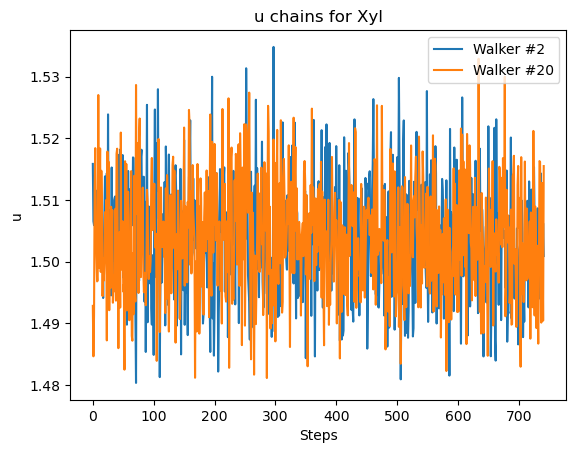

Parameter: v


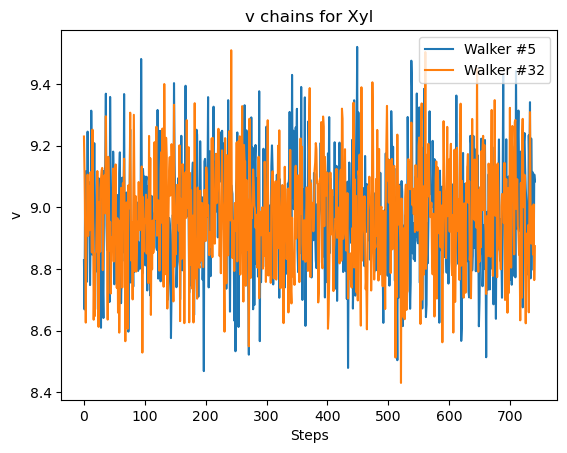

Parameter: k


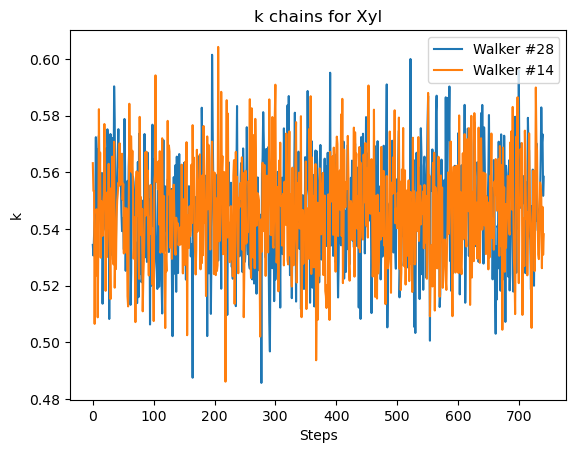

In [163]:
n_walkers = 32  # Adjust to match your sampler's actual walker count
discard = 200
thin = 25
n_params = 7
param_list = ["u", "v", "k"]
n_plotted = 2

# Load chain
flat_chain = np.loadtxt(f"chain_{sugar}.txt")
n_steps_total = flat_chain.shape[0]

# Reshape into (n_steps, n_walkers, n_params)
n_steps = n_steps_total // n_walkers
chain_reshaped = flat_chain.reshape((n_steps, n_walkers, n_params))

# Discard and thin
samples = chain_reshaped[discard::thin]

# Plot walker traces for selected parameters
def chainplot(chains, parameter_index, n_plotted=6, random_pick=False):
    n_walkers = chains.shape[1]
    if random_pick:
        walkers = np.random.choice(np.arange(n_walkers), n_plotted, replace=False)
    else:
        walkers = np.arange(0, n_plotted)
    return walkers

interval = np.arange(samples.shape[0])

for i, param_name in enumerate(param_list):
    print("Parameter:", param_name)
    walkers = chainplot(samples, i, n_plotted=n_plotted, random_pick=True)
    for w in walkers:
        plt.plot(interval, samples[:, w, i], label=f"Walker #{w + 1}")
    plt.legend(loc='upper right')
    plt.xlabel("Steps")
    plt.ylabel(param_name)
    plt.title(f"{param_name} chains for {sugar}")
    plt.savefig(f"model2real_7params_{sugar}_chains_{param_name}.pdf", format="pdf", bbox_inches="tight")
    plt.show()


# Sampling with determistic parameters

In [ ]:
def protein_levels_at_division_pdf(p, alpha, k, tau):
    # Compute the probability density function (PDF) of the protein levels
    return (alpha * k/(tau**k)) * (p**(k-1)) / ((1 + (p/tau)**k)**(alpha + 1))


In [ ]:
def metropolis_hastings(unnorm_pdf, alpha, k, tau, n_samples=100000, proposal_width=1.0, burn_in=50000):
    samples = []
    p_current = np.random.rand() + 0.1  # initial value > 0
    for _ in range(n_samples + burn_in):
        p_proposal = np.random.normal(p_current, proposal_width)
        if p_proposal <= 0:
            continue  # stay in domain

        # Acceptance probability
        p_accept = min(1, unnorm_pdf(p_proposal, alpha, k, tau) / unnorm_pdf(p_current, alpha, k, tau))

        if np.random.rand() < p_accept:
            p_current = p_proposal

        samples.append(p_current)

    return np.array(samples[burn_in:])



In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(15, 12))  # 3x3 grid
axs = axs.flatten()  # flatten so we can index as a list

for i in range(len(fittingParams['u'])):
    alpha = fittingParams['omega2'][i]
    k = fittingParams['v'][i]
    tau = fittingParams['u'][i]

    samples = metropolis_hastings(protein_levels_at_division_pdf, alpha, k, tau)
    posterior_samples = samples
    empirical_protein_level = dfs[names[i]]["protein_level"].dropna()

    ax = axs[i]
    ax.hist(posterior_samples, bins=100, density=True, alpha=0.6, label="MCMC samples", color='C0')
    ax.hist(empirical_protein_level, bins=100, density=True, alpha=0.6, label="Empirical data", color='C1')
    ax.set_xlim(0, 10)
    ax.set_title(f"{names[i]}")
    ax.set_xlabel("Protein level at division")
    ax.set_ylabel("Density")
    ax.legend()

plt.tight_layout()
plt.suptitle("Metropolis–Hastings Posterior vs. Empirical Data", fontsize=16, y=1.02)
plt.show()


In [ ]:
empirical_protein_level = dfs["UMIK_Ace"]["protein_level"]
empirical_protein_level = np.sort(empirical_protein_level)
d = np.diff(empirical_protein_level, n=1)
print(np.sort(d[:10]))
print(np.sum(d[~np.isnan(d)]))
empirical_protein_level = dfs["UMIK_Gly"]["protein_level"]
empirical_protein_level = np.sort(empirical_protein_level)
d = np.diff(empirical_protein_level, n=1)
print(np.sort(d[:10]))
print(np.sum(d[~np.isnan(d)]))
